In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

column_names = ['userId', 'productId', 'Rating', 'timestamp']

file_path = "C:\\Users\\User\\Downloads\\ratings_Electronics (1).csv" 
amazon_data = pd.read_csv(file_path, names=column_names, header=None)

print("Dataset loaded successfully with column names!")
print(amazon_data.head())


Dataset loaded successfully with column names!
           userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200


In [2]:
try:
    amazon_data['Rating'] = pd.to_numeric(amazon_data['Rating'], errors='coerce')
    amazon_data = amazon_data.dropna(subset=['Rating'])
    
    
    amazon_data['Rating'] = amazon_data['Rating'].clip(1, 5).round().astype(int)
    print("Ratings adjusted to 1-to-5 scale successfully!")
except Exception as e:
    print(f"Error during rating adjustment: {e}")


tnu = amazon_data['userId'].nunique()  
tni = amazon_data['productId'].nunique() 

print("\nTotal Number of Users (tnu):", tnu)
print("Total Number of Items (tni):", tni)

Ratings adjusted to 1-to-5 scale successfully!

Total Number of Users (tnu): 4201696
Total Number of Items (tni): 476002


In [3]:
product_ratings_count = amazon_data['productId'].value_counts()
print("\nNumber of Ratings Per Product:")
print(product_ratings_count.head())


active_users = amazon_data['userId'].unique()[:3]
amazon_data.loc[amazon_data['userId'] == active_users[0], 'Rating'] = np.nan
amazon_data.loc[amazon_data['userId'] == active_users[1], 'Rating'] = np.nan
amazon_data.loc[amazon_data['userId'] == active_users[2], 'Rating'] = np.nan

print(f"\nActive Users: U1={active_users[0]}, U2={active_users[1]}, U3={active_users[2]}")


target_items = amazon_data['productId'].unique()[:2]
amazon_data.loc[amazon_data['productId'] == target_items[0], 'Rating'] = np.nan
amazon_data.loc[amazon_data['productId'] == target_items[1], 'Rating'] = np.nan

print(f"Target Items: I1={target_items[0]}, I2={target_items[1]}")


Number of Ratings Per Product:
productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: count, dtype: int64

Active Users: U1=AKM1MP6P0OYPR, U2=A2CX7LUOHB2NDG, U3=A2NWSAGRHCP8N5
Target Items: I1=0132793040, I2=0321732944


In [4]:
no_common_users = amazon_data.groupby('userId')['productId'].count()
no_coRated_items = amazon_data.groupby('productId')['userId'].count()

print("\nNumber of Common Users and Co-Rated Items:")
print("No_common_users:", no_common_users.head())
print("No_coRated_items:", no_coRated_items.head())



Number of Common Users and Co-Rated Items:
No_common_users: userId
A00000262KYZUE4J55XGL    1
A000063614T1OE0BUSKUT    2
A00009182QVLSWIGHLS1B    1
A00009661LC9LQPGKJ24G    1
A00010809P09NUU6ZP6H     1
Name: productId, dtype: int64
No_coRated_items: productId
0132793040     1
0321732944     1
0439886341     3
0511189877     6
0528881469    27
Name: userId, dtype: int64



2D Array (No_common_users, No_coRated_items):
[]


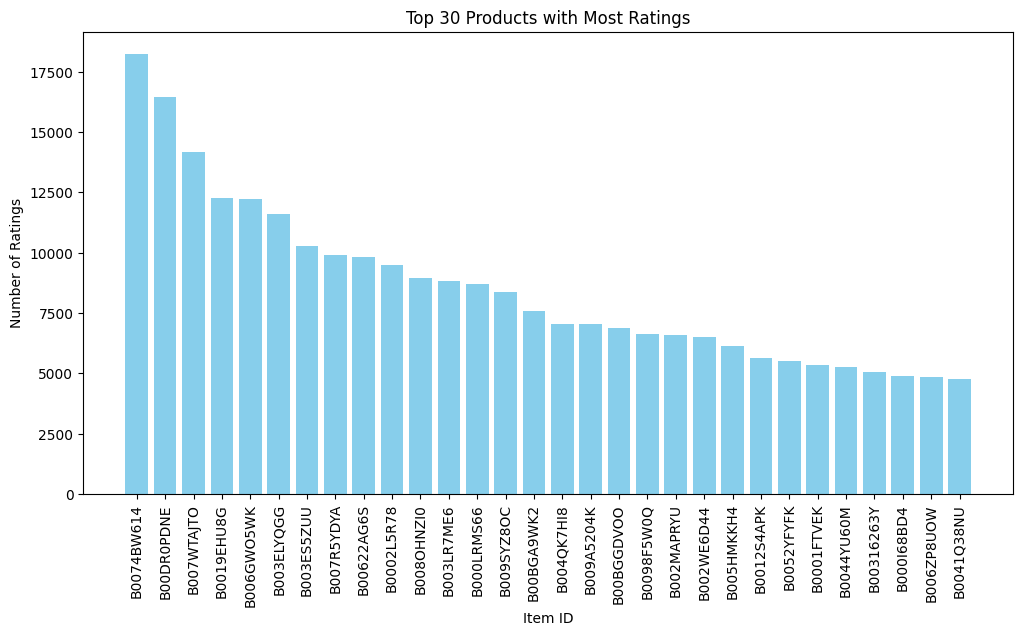


Maximum Users Co-Rating at Least 30% of Items: 4201696


In [5]:
common_indices = no_coRated_items.index.intersection(no_common_users.index)

coRated_array = np.array([
    no_common_users.loc[common_indices].sort_values(ascending=False).values,
    no_coRated_items.loc[common_indices].values
]).T

print("\n2D Array (No_common_users, No_coRated_items):")
print(coRated_array)

plt.figure(figsize=(12, 6))
plt.bar(product_ratings_count.index[:30], product_ratings_count.values[:30], color='skyblue')
plt.title("Top 30 Products with Most Ratings")
plt.xlabel("Item ID")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=90)
plt.show()

threshold = 0.3
total_items = len(target_items)

coRated_threshold = amazon_data.groupby('userId')['productId'].count().apply(
    lambda x: x / total_items >= threshold
).sum()

print(f"\nMaximum Users Co-Rating at Least {int(threshold * 100)}% of Items: {coRated_threshold}")

results = {
    "product_ratings_count": product_ratings_count,
    "active_users": active_users,
    "target_items": target_items,
    "no_common_users": no_common_users,
    "no_coRated_items": no_coRated_items,
    "coRated_array": coRated_array,
    "coRated_threshold_users": coRated_threshold
}

Part 1 :Case Study 1.1

In [6]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

file_path = "C:\\Users\\User\\Downloads\\ratings_Electronics (1).csv"
amazon_data = pd.read_csv(file_path, header=None, names=['userId', 'productId', 'Rating', 'timestamp'])


user_rating_count = amazon_data['userId'].value_counts()
filtered_users = user_rating_count[user_rating_count >= 50].index


item_rating_count = amazon_data['productId'].value_counts()
filtered_items = item_rating_count[item_rating_count >= 50].index


filtered_data = amazon_data[
    amazon_data['userId'].isin(filtered_users) & amazon_data['productId'].isin(filtered_items)
]

print(f"Dataset reduced to {filtered_data.shape[0]} rows, {len(filtered_users)} users, and {len(filtered_items)} items.")

Dataset reduced to 79182 rows, 1540 users, and 26226 items.


In [7]:
user_item_matrix = filtered_data.pivot_table(index='userId', columns='productId', values='Rating', fill_value=0)

print("User-Item Matrix:")
print(user_item_matrix.head())

user_similarity = cosine_similarity(user_item_matrix)


user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

print("\nUser Similarity Matrix (Cosine Similarity):")
print(user_similarity_df.head())

User-Item Matrix:
productId       0972683275  1400501466  1400501520  1400501776  1400532620  \
userId                                                                       
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0         0.0         0.0         0.0   
A10AFVU66A79Y1         0.0         0.0         0.0         0.0         0.0   

productId       1400532655  140053271X  1400599997  1400698987  3744295508  \
userId                                                                       
A100UD67AHFODS         0.0         0.0         0.0         0.0         0.0   
A100WO06OQR8BQ         0.0         0.0         0.0         0.0         0.0   
A105S56ODHGJEK         0.0         0.0         0.0         0.0         0.0   
A105TOJ6LTVMBG         0.0         0.0       

In [8]:
import numpy as np

active_users = user_item_matrix.index[:3] 


def get_top_20_percent(similarity_matrix, active_users):
    top_users = {}
    for user in active_users:
        
        similarities = similarity_matrix.loc[user]
        
        
        sorted_similarities = similarities.drop(index=user).sort_values(ascending=False)
        
        
        top_n = int(len(sorted_similarities) * 0.2)
        top_users[user] = sorted_similarities.iloc[:top_n]
    return top_users


top_20_percent_users = get_top_20_percent(user_similarity_df, active_users)


for user, top_users in top_20_percent_users.items():
    print(f"\nTop 20% closest users to Active User '{user}':")
    print(top_users)



Top 20% closest users to Active User 'A100UD67AHFODS':
userId
A2FZQF0MH29VYN    0.081493
A2NOW4U7W3F7RI    0.079461
AT53ZTTO707MB     0.078669
A2DG63DN704LOI    0.067041
A11FX8HL2ANK6T    0.066851
                    ...   
AWZR0O65DL2Q      0.018867
A105TOJ6LTVMBG    0.018806
A14MZJTZAQS6CV    0.018795
A5Q1FK0FWU7DH     0.018785
A6KL17KKN0A5L     0.018722
Name: A100UD67AHFODS, Length: 307, dtype: float64

Top 20% closest users to Active User 'A100WO06OQR8BQ':
userId
A3963R7EPE3A7E    0.111641
A2L4ZGN7GZJ95T    0.094402
A1CST2WUA32GP0    0.093533
A18S2VGUH9SCV5    0.091595
A3D822N1K2IAQD    0.091273
                    ...   
A3TNM3C9ENUCFW    0.034943
A2GMZZ6TDYOHY7    0.034932
A3F3B6HY9RJI04    0.034924
A2UKE7GIVC7XFW    0.034841
A2UOHALGF2X77Q    0.034562
Name: A100WO06OQR8BQ, Length: 307, dtype: float64

Top 20% closest users to Active User 'A105S56ODHGJEK':
userId
A17UNMURMLX0ZE    0.192787
A2LF16F0KX9L7P    0.168174
A2UKE7GIVC7XFW    0.152467
ABMNX856X89CS     0.151309
AJX9A4Q19